# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

2022-09-29 10:38:05.465672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (128, 128, 128), (128, 128, 128)
num_epoch = 200
batch_size = 1000

# Load and Process Data

In [3]:
signal_1_df = "/global/home/users/yifengh3/VAE/vec_data/signal/muon_only/B_signal_vector_muons_fixed.h5"
signal_2_df = "/global/home/users/yifengh3/VAE/vec_data/signal/muon_only/hv_vector_muons.h5"
raw_signal_1 = pandas.read_hdf(signal_1_df)
raw_signal_2 = pandas.read_hdf(signal_2_df)

In [4]:
print("signal_1 data shape: {}".format(raw_signal_1.shape))
print("signal_2 data shape: {}".format(raw_signal_2.shape))

signal_1 data shape: (173270, 8)
signal_2 data shape: (155841, 200)


In [5]:
#Truncate the nan
signal_1 = raw_signal_1.to_numpy()[:,:8]
signal_2 = raw_signal_2.to_numpy()[:,:8]

In [6]:
np.mean(signal_1,axis=0)

array([ 8.51122132e+00, -2.32930321e-03,  3.29362630e-03,  8.51122132e+00,
        8.51186841e+00,  1.54096152e-03,  3.47732437e-03,  8.51186841e+00])

In [7]:
print("signal_1 data shape: {}".format(signal_1.shape))
print("signal_2 data shape: {}".format(signal_2.shape))

signal_1 data shape: (173270, 8)
signal_2 data shape: (155841, 8)


In [8]:
# assign labels to signal and background data, 0 for sig1,  1 for sig2
# (updated since we might get multiple signals) 
labeled_sig1 = np.append(signal_1,np.zeros((signal_1.shape[0],1)),axis=1)
labeled_sig2 = np.append(signal_2,np.ones((signal_2.shape[0],1)),axis=1)

In [9]:
# mix two data array into one signal array
data = np.concatenate((labeled_sig1,labeled_sig2))

#and shuffle the data
np.random.shuffle(data)

In [10]:
X = data[:,:-1].astype("float")
y = data[:,-1]

In [11]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (329111, 8)
shape of Y: (329111,)


In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = labeled_sig1.shape[0] + labeled_sig2.shape[0]
weight_for_0 = (1 / labeled_sig1.shape[0]) * (total / 2.0)
weight_for_1 = (1 / labeled_sig2.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.95
Weight for signal: 1.06


In [13]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 4)
X = X.reshape(-1,2,4)

# ignore the pid info
X = X[:,:,:3]

In [14]:
print(X.shape)

(329111, 2, 3)


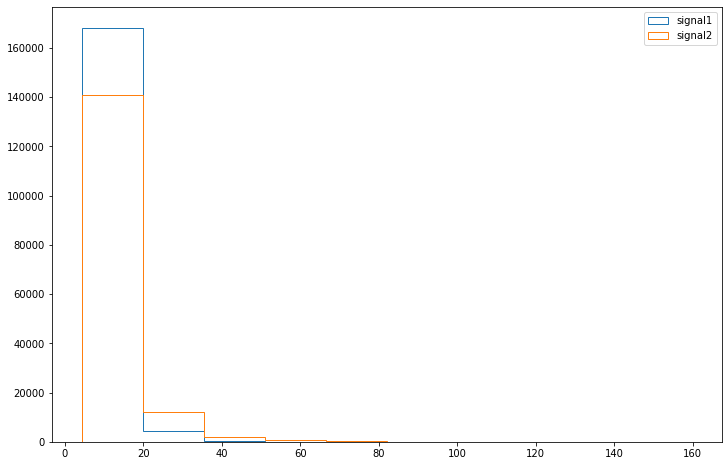

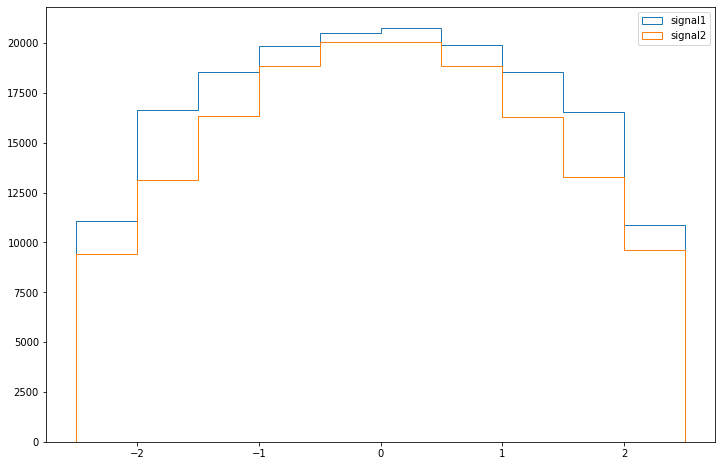

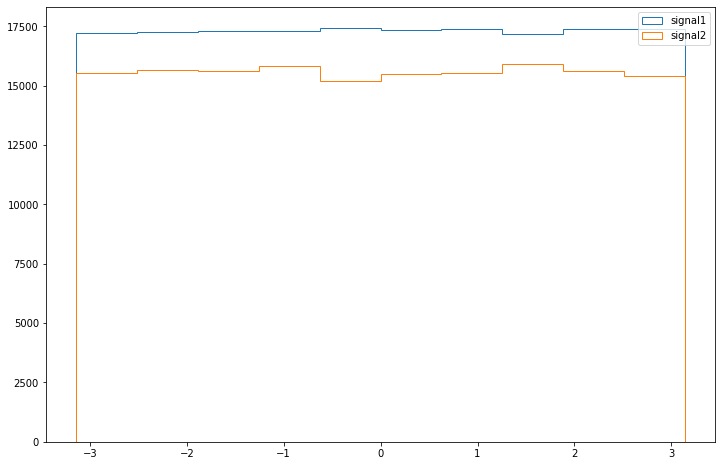

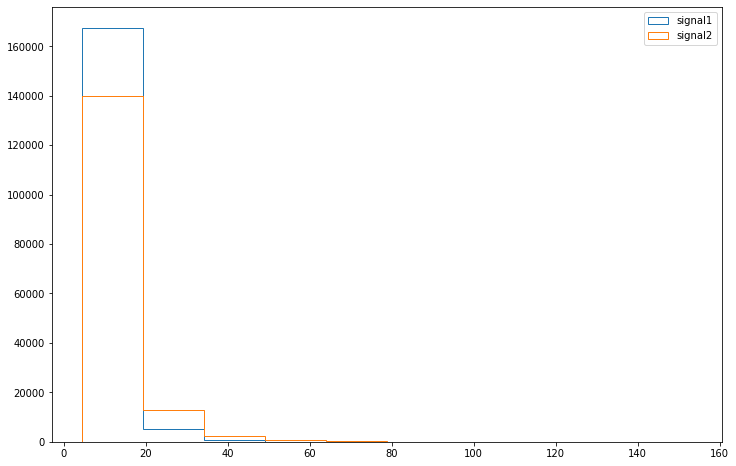

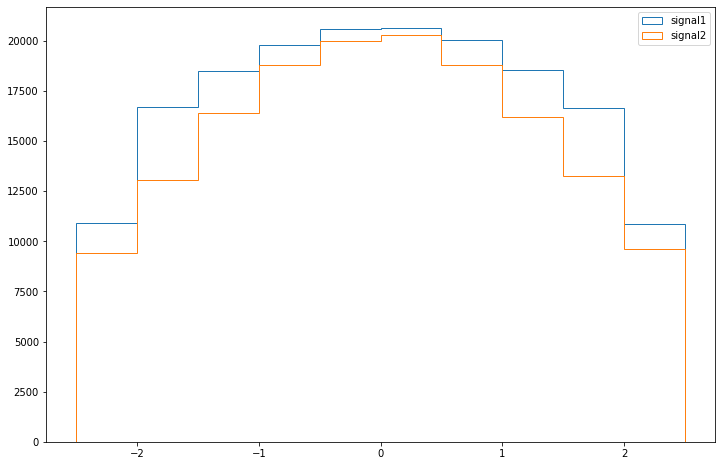

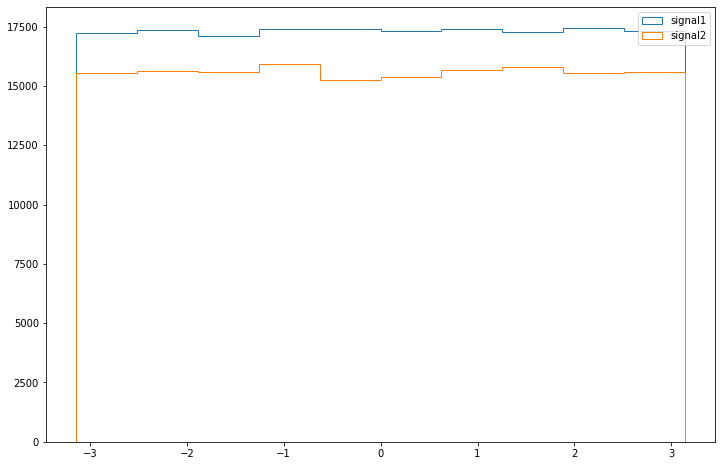

In [15]:
for i in range(6):
    plt.figure(figsize=(12,8))
    _,b,_ = plt.hist(X.reshape([-1,6])[y==0,i], label="signal1", histtype="step")
    plt.hist(X.reshape([-1,6])[y==1,i], label="signal2", histtype="step", bins=b)
    plt.legend()
    plt.show()

In [16]:
# # normalizing jets
# # copied from example
# import tqdm
# for x in tqdm.tqdm(X):
#     # now add the status bar :)
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()

In [17]:
%cd ../recon_kinematic_plot

/global/home/users/yifengh3/VAE/EMD_VAE/recon_kinematic_plot


In [18]:
from plot_utils import event_mass

In [19]:
X[y==1].dtype

dtype('float64')

In [20]:
em1 = event_mass(X[y==0])
em2 = event_mass(X[y==1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 155841/155841 [00:05<00:00, 30658.77it/s]


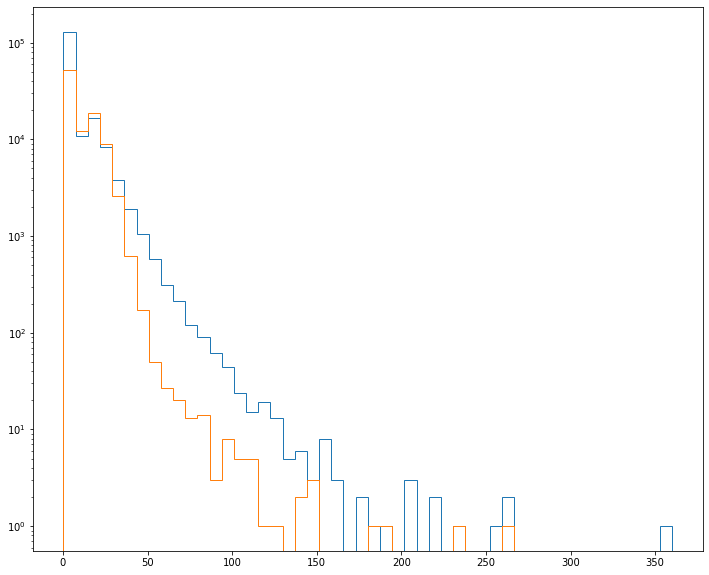

In [21]:
plt.figure(figsize=(12,10))
_,b,_ = plt.hist(em1, label = "EM_sig1", histtype="step", bins=50)
plt.hist(em2, label = "EM_sig2", bins=b, histtype="step")
plt.yscale("log")
plt.show()

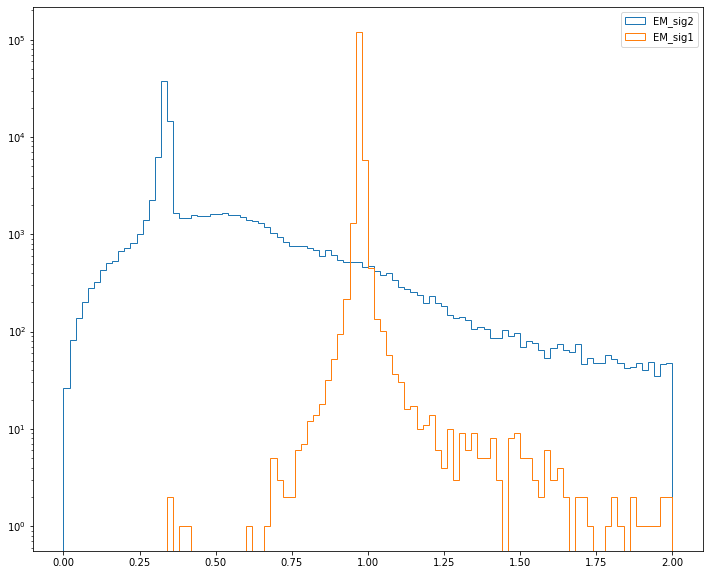

In [22]:
plt.figure(figsize=(12,10))
_,b,_ = plt.hist(em2[em2<2], label = "EM_sig2", histtype="step", bins=100)
plt.hist(em1[em1<2], label = "EM_sig1", bins=b, histtype="step")
plt.yscale("log")
plt.legend()
plt.show()

In [23]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (329111, 2, 3)
shape of Y: (329111,)


In [24]:
X = X.astype('float64')

In [25]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [26]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:


2022-09-29 10:38:39.977720: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 10:38:39.978710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 10:38:40.001809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-29 10:38:40.001829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-29 10:38:40.003204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-29 10:38:40.003234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 128)    512         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 128)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 128)    16512       activation[0][0]                 
______________________________________________________________________________________________

In [27]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/4), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/200


2022-09-29 10:38:40.967990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-29 10:38:40.968460: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz
2022-09-29 10:38:41.367117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


198/198 [==============================] - 2s 5ms/step - loss: 2.3450 - acc: 0.5524 - val_loss: 0.6547 - val_acc: 0.6052
Epoch 2/200
198/198 [==============================] - 1s 3ms/step - loss: 0.6545 - acc: 0.6120 - val_loss: 0.6486 - val_acc: 0.6300
Epoch 3/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6595 - acc: 0.6110 - val_loss: 0.6493 - val_acc: 0.6280
Epoch 4/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6538 - acc: 0.6222 - val_loss: 0.6436 - val_acc: 0.6324
Epoch 5/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6488 - acc: 0.6296 - val_loss: 0.6482 - val_acc: 0.6195
Epoch 6/200
198/198 [==============================] - 1s 3ms/step - loss: 0.6470 - acc: 0.6325 - val_loss: 0.6493 - val_acc: 0.6341
Epoch 7/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6443 - acc: 0.6372 - val_loss: 0.6473 - val_acc: 0.6206
Epoch 8/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6464

Epoch 62/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6154 - acc: 0.6620 - val_loss: 0.6193 - val_acc: 0.6564
Epoch 63/200
198/198 [==============================] - 1s 3ms/step - loss: 0.6143 - acc: 0.6632 - val_loss: 0.6175 - val_acc: 0.6594
Epoch 64/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6156 - acc: 0.6613 - val_loss: 0.6173 - val_acc: 0.6602
Epoch 65/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6142 - acc: 0.6626 - val_loss: 0.6158 - val_acc: 0.6616
Epoch 66/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6148 - acc: 0.6632 - val_loss: 0.6173 - val_acc: 0.6591
Epoch 67/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6142 - acc: 0.6615 - val_loss: 0.6188 - val_acc: 0.6575
Epoch 68/200
198/198 [==============================] - 1s 4ms/step - loss: 0.6156 - acc: 0.6625 - val_loss: 0.6167 - val_acc: 0.6600
Epoch 69/200
198/198 [==============================] - 1s 3ms

# Analyze the Model

In [28]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.7190679073240156



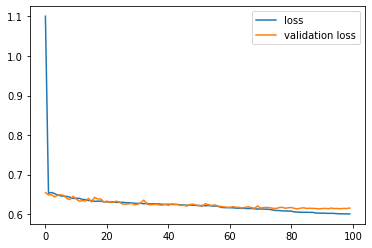

In [29]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

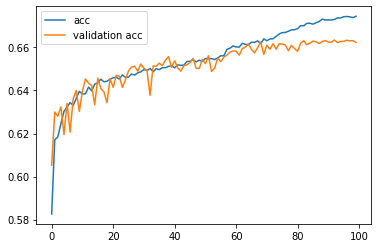

In [30]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()

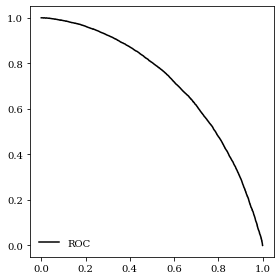

In [31]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='ROC')

plt.legend(loc='lower left', frameon=False)

plt.show()

/tmp/ipykernel_5836/1246046417.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')


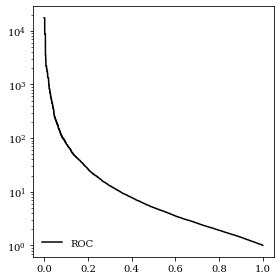

In [32]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')

plt.yscale('log')

plt.legend(loc='lower left', frameon=False)

plt.show()